In [1]:
import os
from pathlib import Path

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from fastai.tabular.all import *
from fastai.metrics import R2Score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [4]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [5]:
path = Path('/kaggle/input/larger-whoop-data')
df = pd.read_csv(path/'physiological_cycles.csv')

In [6]:
df.shape

(707, 26)

In [7]:
def preprocess_data(df):
    df_clean = df.copy()

    if 'Sleep efficiency %' in df_clean.columns:
        df_clean = df_clean.dropna(subset=['Sleep efficiency %'])

    if 'Asleep duration (min)' in df_clean.columns:
        df_clean = df_clean[df_clean['Asleep duration (min)'] >= 300]

    if all(col in df_clean.columns for col in [
        'Deep (SWS) duration (min)',
        'REM duration (min)',
        'Light sleep duration (min)',
        'Asleep duration (min)'
    ]):
        df_clean['Deep sleep ratio'] = df_clean['Deep (SWS) duration (min)'] / df_clean['Asleep duration (min)']
        df_clean['REM sleep ratio'] = df_clean['REM duration (min)'] / df_clean['Asleep duration (min)']
        df_clean['Light sleep ratio'] = df_clean['Light sleep duration (min)'] / df_clean['Asleep duration (min)']
        
    columns_to_drop = [
        'Cycle start time',
        'Cycle end time',
        'Cycle timezone',
        'Day Strain',
        'Energy burned (cal)',
        'Max HR (bpm)',
        'Average HR (bpm)',
        'Sleep onset',
        'Wake onset',
    ]
    
    columns_to_drop = [col for col in columns_to_drop if col in df_clean.columns]
    df_clean = df_clean.drop(columns=columns_to_drop)

    numeric_columns = df_clean.select_dtypes(include=np.number).columns
    for col in numeric_columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        
    return df_clean

In [8]:
df.columns

Index(['Cycle start time', 'Cycle end time', 'Cycle timezone', 'Recovery score %', 'Resting heart rate (bpm)',
       'Heart rate variability (ms)', 'Skin temp (celsius)', 'Blood oxygen %', 'Day Strain', 'Energy burned (cal)', 'Max HR (bpm)',
       'Average HR (bpm)', 'Sleep onset', 'Wake onset', 'Sleep performance %', 'Respiratory rate (rpm)', 'Asleep duration (min)',
       'In bed duration (min)', 'Light sleep duration (min)', 'Deep (SWS) duration (min)', 'REM duration (min)', 'Awake duration (min)',
       'Sleep need (min)', 'Sleep debt (min)', 'Sleep efficiency %', 'Sleep consistency %'],
      dtype='object')

In [9]:
df_clean = preprocess_data(df)
df_clean

,Recovery score %,Resting heart rate (bpm),Heart rate variability (ms),Skin temp (celsius),Blood oxygen %,Sleep performance %,Respiratory rate (rpm),Asleep duration (min),In bed duration (min),Light sleep duration (min),Deep (SWS) duration (min),REM duration (min),Awake duration (min),Sleep need (min),Sleep debt (min),Sleep efficiency %,Sleep consistency %,Deep sleep ratio,REM sleep ratio,Light sleep ratio
0,72.00,55.00,47.00,33.86,97.56,66.00,14.10,394.00,450.00,133.00,129.00,132.00,56.00,595.00,123.00,87.00,71.00,0.33,0.34,0.34
2,55.00,64.00,39.00,31.68,97.92,60.00,14.50,367.00,419.00,152.00,149.00,66.00,52.00,615.00,108.00,87.00,63.00,0.41,0.18,0.41
3,43.00,62.00,34.00,32.20,97.17,59.00,14.90,314.00,367.00,139.00,87.00,88.00,53.00,530.00,9.00,85.00,59.00,0.28,0.28,0.44
4,58.00,64.00,38.00,32.72,97.33,97.00,14.80,548.00,632.00,279.00,134.00,135.00,84.00,564.00,91.00,86.00,56.00,0.24,0.25,0.51
5,21.00,77.00,22.00,33.91,97.45,75.00,15.20,416.00,469.00,214.00,111.00,91.00,53.00,558.00,85.00,88.00,80.00,0.27,0.22,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,93.00,54.00,80.00,32.90,97.14,76.00,14.20,453.00,507.00,185.00,96.00,172.00,54.00,594.00,118.00,89.00,70.00,0.21,0.38,0.41
700,43.00,62.00,39.00,34.40,96.36,77.00,14.90,445.00,484.00,206.00,134.00,105.00,39.00,579.00,101.00,91.00,67.00,0.30,0.24,0.46
702,42.00,61.00,59.00,34.50,96.33,57.00,15.10,335.00,416.00,165.00,94.00,76.00,81.00,587.00,111.00,80.00,60.00,0.28,0.23,0.49
704,21.00,78.00,23.00,33.15,96.85,69.00,15.30,371.00,397.00,255.00,68.00,48.00,26.00,540.00,47.00,94.00,75.00,0.18,0.13,0.69


In [10]:
df_clean, test_df_clean = train_test_split(df_clean, test_size=0.2, random_state=42)

In [11]:
test_df_clean.shape

(128, 20)

In [12]:
df_clean.shape

(508, 20)

In [13]:
target_col = 'Recovery score %'
cont_cols = [col for col in df_clean.columns if col != target_col and df_clean[col].dtype != 'object']
cat_cols = [col for col in df_clean.columns if col != target_col and df_clean[col].dtype == 'object']

In [14]:
splits = RandomSplitter(seed=42)(df_clean)

In [15]:
procs = [Categorify, FillMissing, Normalize]

In [16]:
dls = TabularPandas(
    df_clean, splits=splits,
    procs = procs,
    cat_names = cat_cols,
    cont_names = cont_cols,
    y_names=target_col,
    y_block=RegressionBlock(),
).dataloaders(path=".")

In [17]:
config = tabular_config(
    ps=[0.2, 0.1]
)

In [18]:
learn = tabular_learner(dls,
                        layers=[10, 10],
                        config=config,
                        metrics=[rmse, mae, R2Score()],
                        cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.05, patience=2)],
                       )

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(slide=6.309573450380412e-07, valley=0.033113110810518265)

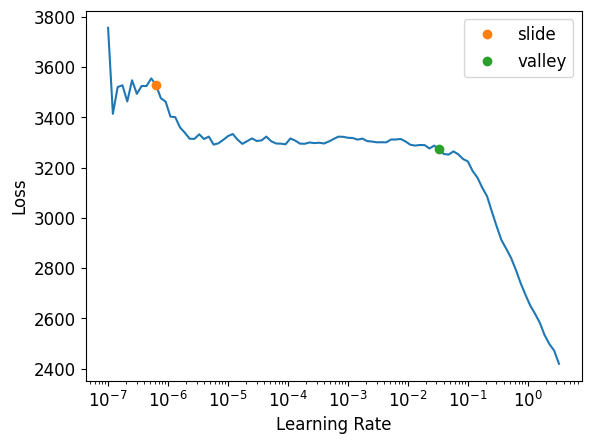

In [19]:
learn.lr_find(suggest_funcs=(slide, valley))

In [20]:
learn.fit_one_cycle(35, 0.02)

epoch,train_loss,valid_loss,_rmse,mae,r2_score,time
0,3257.207520,3863.406494,62.156307,57.462757,-5.888324,00:00
1,3263.198975,3856.126953,62.097721,57.413860,-5.875345,00:00
2,3227.612549,3839.110107,61.960552,57.326424,-5.845004,00:00
3,3186.967041,3806.533691,61.697113,57.193779,-5.786922,00:00
4,3165.086670,3728.541992,61.061787,56.865971,-5.647865,00:00
5,3116.961426,3575.948975,59.799240,56.193077,-5.375797,00:00
6,3067.353516,3412.498535,58.416595,55.532585,-5.084370,00:00
7,2996.743408,3267.671143,57.163544,55.247776,-4.826148,00:00
8,2925.894287,3062.532227,55.340149,54.310120,-4.460392,00:00
9,2805.242920,2676.400391,51.733940,51.107819,-3.771932,00:00


No improvement since epoch 22: early stopping


In [21]:
test_dl = learn.dls.test_dl(test_df_clean, y=test_df_clean[target_col])

In [22]:
test_loss, *test_metrics = learn.validate(dl=test_dl)

In [23]:
print(f"Test Loss: {test_loss}")

Test Loss: 58.84971237182617


In [24]:
for i, metric_value in enumerate(test_metrics):
    metric_name = learn.metrics[i].name
    print(f"Test {metric_name}: {metric_value:.4f}")

Test _rmse: 7.6714
Test mae: 6.3678
Test r2_score: 0.8787


In [25]:
def create_ensemble_learner(dls, layers, ps, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    config = tabular_config(ps=ps)
    learn = tabular_learner(dls,
                            layers=layers,
                            config=config,
                            metrics=[rmse, mae, R2Score()],  # Or your classification metrics
                            cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)])
    return learn

In [26]:
def train_ensemble(dls, n_models=5, layers=[10, 10], ps=[0.2, 0.1], epochs=35, lr=0.02, seeds=None):
    learners = []
    for i in range(n_models):
        seed = seeds[i] if seeds else (42 + i)
        learn = create_ensemble_learner(dls, layers, ps, seed)
        with learn.no_bar(), learn.no_logging():
            learn.fit(epochs, lr=lr)
        learners.append(learn)
    return learners

In [27]:
def get_ensemble_predictions(learners, test_dl):
    all_preds = [learn.get_preds(dl=test_dl)[0] for learn in learners]
    avg_preds = torch.mean(torch.stack(all_preds), dim=0).numpy().flatten()
    return avg_preds

In [28]:
def evaluate_ensemble(learners, test_df_clean, dep_var):
    test_dl = learners[0].dls.test_dl(test_df_clean, y=test_df_clean[dep_var])
    ensemble_preds = get_ensemble_predictions(learners, test_dl)
    true_targets = test_df_clean[dep_var].values.flatten()

    rmse_ensemble = np.sqrt(mean_squared_error(true_targets, ensemble_preds))
    mae_ensemble = mean_absolute_error(true_targets, ensemble_preds)
    r2_ensemble = r2_score(true_targets, ensemble_preds)

    print("Ensemble Test Results:")
    print(f"Ensemble RMSE: {rmse_ensemble:.4f}")
    print(f"Ensemble MAE: {mae_ensemble:.4f}")
    print(f"Ensemble R2 Score: {r2_ensemble:.4f}")

In [29]:
learners = train_ensemble(dls, n_models=5)

No improvement since epoch 22: early stopping
No improvement since epoch 21: early stopping
No improvement since epoch 20: early stopping
No improvement since epoch 19: early stopping
No improvement since epoch 20: early stopping


In [30]:
evaluate_ensemble(learners, test_df_clean, target_col)

Ensemble Test Results:
Ensemble RMSE: 6.8128
Ensemble MAE: 5.7977
Ensemble R2 Score: 0.9043


In [31]:
learn.export('nn_model.pkl')

In [32]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('nn_model.pkl')]